# Generating Gamma Surfaces & Stacking Fault

Gamma surfaces (also called generalised stacking faults) and stacking faults are forms of crystal defects formed by sliding two slabs of a crystal against each other along a given plane. Often, these defects have metastable states (also called stacking faults), which can exist at grain boundaries or between two partial dislocations. Here, we deal with the full pathway from a complete crystal, sliding through any metastable points until we return back to the perfect crystal again. 

For a stacking fault, the slabs are moved along a single line, whereas for gamma surfaces this is the full plane (hence generalised stacking fault). `matscipy.gamma_surface` provides two classes - `GammaSurface` and `StackingFault` - in order to model these systems, including utility methods for relaxing and plotting the associated potential energy surfaces.

## Stacking Faults for a Specific Dislocation
When modelling systems of dissociated dislocations connected by a stacking fault, it can be useful to see the stacking fault in isolation. To do this, we will use `matscipy.gamma_surface.StackingFault` to model the stacking fault associated with the dissociated `matscipy.dislocations.DiamondGlideScrew` dislocation in Carbon. 

We will first use a potential by  to obtain reasonable guesses for a lattice parameter and elastic constants, and take a look at the dissociated `DiamondGlideScrew` dislocation:

In [27]:
from matscipy.dislocation import DiamondGlideScrew, get_elastic_constants
from matscipy.gamma_surface import StackingFault, GammaSurface
from matscipy.calculators.manybody.explicit_forms.tersoff_brenner import TersoffBrenner, Brenner_PRB_42_9458_C_I
from matscipy.calculators.manybody import Manybody
from visualisation import show_dislocation, show_stacking_fault

calc = Manybody(**TersoffBrenner(Brenner_PRB_42_9458_C_I))

# the function accepts any ASE type of calculator
alat, C11, C12, C44 = get_elastic_constants(calculator=calc, symbol="C")
print(f"alat = {alat}")
C_screw = DiamondGlideScrew(alat, C11, C12, C44, symbol="C")

C_screw_bulk, C_screw_dislo = C_screw.build_cylinder(radius=25, partial_distance=20)

view = show_dislocation(C_screw_dislo, 
                 diamond_structure=True, # bonds make it a bit easier to see the structure
                 scale=0.3, add_bonds=True, 
                 partial_distance=20 * C_screw.glide_distance, 
                 d_name="1/6<112> 30 degree partial screw") 

view.control.zoom(0.7)
view

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:15:59      -71.023173*      21.6660
FIRE:    1 14:15:59      -70.778252*      27.1719
FIRE:    2 14:15:59      -72.074178*       7.7128
FIRE:    3 14:15:59      -71.810725*      12.8423
FIRE:    4 14:15:59      -71.909801*      11.1435
FIRE:    5 14:15:59      -72.057595*       7.8693
FIRE:    6 14:15:59      -72.174468*       3.3124
FIRE:    7 14:15:59      -72.190180*       2.0030
FIRE:    8 14:15:59      -72.190836*       1.9252


FIRE:    9 14:15:59      -72.192047*       1.7727
FIRE:   10 14:15:59      -72.193627*       1.5519
FIRE:   11 14:15:59      -72.195333*       1.2717
FIRE:   12 14:15:59      -72.196904*       0.9434
FIRE:   13 14:15:59      -72.198103*       0.5801
FIRE:   14 14:15:59      -72.198751*       0.1961
FIRE:   15 14:15:59      -72.198716*       0.2336
FIRE:   16 14:15:59      -72.198718*       0.2309
FIRE:   17 14:15:59      -72.198724*       0.2256
FIRE:   18 14:15:59      -72.198731*       0.2177
FIRE:   19 14:15:59      -72.198741*       0.2072
FIRE:   20 14:15:59      -72.198752*       0.1944
FIRE:   21 14:15:59      -72.198765*       0.1794
FIRE:   22 14:15:59      -72.198777*       0.1623
FIRE:   23 14:15:59      -72.198791*       0.1412
FIRE:   24 14:15:59      -72.198806*       0.1156
FIRE:   25 14:15:59      -72.198819*       0.0851
FIRE:   26 14:15:59      -72.198829*       0.0495
FIRE:   27 14:15:59      -72.198835*       0.0087
FIRE:   28 14:15:59      -72.198832*       0.0364


NGLWidget()

To model just the stacking fault, we can call `StackingFault` with just the lattice constant, crystalstructure (one of "fcc", "bcc", "diamond"), the chemical symbol, and the kind of dissociated dislocation, and use the function `StackingFault.generate_images()` to generate the fault images.

In [10]:
fault = StackingFault(alat, DiamondGlideScrew, symbol="C")
fault.generate_images(n=16) # Generate 16 images along the pathway
show_stacking_fault(fault.images)

Now that we have the images generated, we can use the calculator by [D. Holland and M. Marder](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.80.746) to relax the images, and look at the energy barrier associated with forming the stacking fault.

There are many things to consider when measuring stacking fault energy densities, and there are many conventions found in literature. Here, we only look at relaxations of these systems, but there are still many parameters to explore. We should consider whether the system should be vacuum terminated, how far apart the periodic images of the stacking fault should be, what constraints to add to the system, and whether there could be another plane with the same normal that could be more energetically favourable.

This is a lot to consider, so we will explore the effect of tuning these parameters now.

### Parameterising stacking fault image generation

The default behaviour of `StackingFault.generate_images()` is to build as small of a cell as possible, based on the output of either `ase.lattice.cubic` (when `a` is a lattice parameter), or `ase.build.bulk`. This is likely to suffer from finite size effects for most systems, so it may be useful to include more bulk between periodic images of a stacking fault. We will also add a vacuum layer between the faults, as this is a common methodology in the literature.

In [11]:
# Re-running fault.generate_images() will replace the images
fault.generate_images(
    n=16, # Still generate 16 images
    z_replications=4, # Add copies of the bulk between stacking faults
    vacuum=10.0 # Add vacuum layer between stakcing faults
)
show_stacking_fault(fault.images)


We can see that this gives a stacking fault with more bulk.
Next, let's relax the fault and look at the energy barrier.

### Relaxing stacking fault images

To relax the stacking fault images, we can use `StackingFault.relax_images`. Here, we have more choices to make, mainly through which constraints we apply to the images, which are controlled by the arguments `constrain_atoms` and `cell_relax`. As the name suggests, `constrain_atoms` adds atomic constraints, which restrict the atoms to only relax in the Z direction (towards or away from the stacking fault). The `cell_relax` argument allows the length of the cell in Z (`image.cell[2, 2]`) to be relaxed.

Because we added a vacuum layer, it is inefficient to try to relax the cell, therefore we will use `cell_relax=False`. We will then use `StackingFault.get_surface_energies()` to evaluate the energy barrier associated with the stacking fault.

NOTE: With stacking faults, we actually measure the energy __density__ (energy per unit area of the stacking fault), which is often expressed in $\text{eV/}\AA^2$ or in $\text{J/m}^2$. We return with $\text{eV/}\AA^2$ in `StackingFault.get_surface_energies()`.

In [12]:
fault.relax_images(calc, cell_relax=False)
Es = fault.get_surface_energies(calc)

Now that we have relaxed the images and found the energy barrier, we should see what the barrier looks like. One way of doing this is to use the inbuilt `StackingFault.plot_gamma_surface()` function:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'(1 1 1) Stacking Fault\nSurface Separation = 33.28${\\AA}$'}, xlabel='Position along (1 1 -2) path', ylabel='Energy Density (eV/${\\AA}^2$)'>)

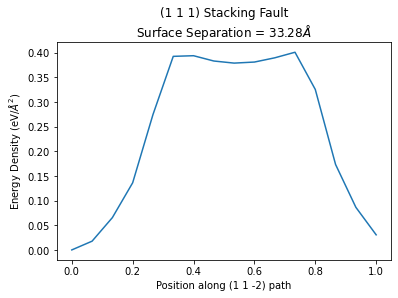

In [13]:
fault.plot_gamma_surface()

We can see that the potential predicts a $\sim 0.40eV/\AA^2$ barrier, a shallow metastable state, and then a new minimum state with formation energy $\sim 0.05eV/\AA^2$ - this new state is exactly the stacking fault we see in the dislocation.

## Gamma Surfaces without a dislocation

All of the above applies to the `GammaSurface` class as well, with the exception that `GammaSurface.generate_images()` requires `nx` and `ny` as arguments, rather than the `n` argument from `StackingFault.generate_images()` (we need to define a grid of points, rather than a line).

When using `GammaSurface` with a dislocation, `ny` will control the number of points in the direction of the stacking fault we see in that dislocation (`GammaSurface.generate_images(nx=1, ny=n)` is essentially equivalent to `StackingFault.generate_images(n=n)`). However, there exist a wide range of stacking faults and gamma surfaces that may not be linked to a dissociated dislocation in `matscipy.dislocation`.

In order to generate stacking faults and gamma surfaces in any desired direction, we need a well-defined normal vector in miller index notation. In this example, we will take the normal to be (001). As a test system, lets use BCC Tungsten and the EAM4 potential by [Marinica _et. al._](http://dx.doi.org/10.1088/0953-8984/25/39/395502).

In [16]:
from matscipy.calculators.eam import EAM
calc = EAM("../../tests/w_eam4.fs")

alat, C11, C12, C44 = get_elastic_constants(calculator=calc, symbol="W")
surface = GammaSurface(alat, surface_direction=[0, 0, 1], crystalstructure="bcc", symbol="W")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 13:44:32      -17.792788*       1.5616
FIRE:    1 13:44:32      -17.796007*       1.2330
FIRE:    2 13:44:32      -17.798904*       0.6354
FIRE:    3 13:44:32      -17.799853*       0.2223
FIRE:    4 13:44:32      -17.799882*       0.1976
FIRE:    5 13:44:32      -17.799928*       0.1509
FIRE:    6 13:44:32      -17.799970*       0.0870
FIRE:    7 13:44:32      -17.799991*       0.0130
FIRE:    8 13:44:32      -17.799981*       0.0629
FIRE:    9 13:44:32      -17.799981*       0.0611
FIRE:   10 13:44:32      -17.799982*       0.0576
FIRE:   11 13:44:32      -17.799984*       0.0525
FIRE:   12 13:44:32      -17.799986*       0.0458
FIRE:   13 13:44:32      -17.799988*       0.0379
FIRE:   14 13:44:32      -17.799989*       0.0289
FIRE:   15 13:44:32      -17.799991*       0.0191
FIRE:   16 13:44:32      -17.799991*       0.0076
FIRE:   17 13:44:32      -17.799992*       0.0052
FI

To do a gamma surface or stacking fault calculation, we need a complete orthogonal basis, however we only supplied a single basis vector. Internally, the code has searched for a reasonable choice of basis on the assumption that "good" bases have integer miller indeces, and that the size of these integers should be close to zero.

To see what the full basis is in miller index notation, we can look at the `surf_directions` dict:

In [19]:
print(surface.surf_directions)

{'x': array([0, 1, 0]), 'y': array([-1,  0,  0]), 'z': array([0, 0, 1])}


The (001) direction we set as the normal to the surface is chosen to be in the z direction. The code has then found that (010) and (-100) are two directions that result in a "sensible" basis for performing out calculations. 

In the `get_surface_energies()` function, there is an optional argument `relax` which internally calls `relax_images`. This means we can relax the images and get associated energy densities all from one function call.

In [20]:
surface.generate_images(nx=5,
                        ny=5,
                        z_replications=4)

Es = surface.get_surface_energies(calc, relax=True)

Now that the images are relaxed, we can plot the energy density of the system across the full surface. We will also use the `si=True` argument in the plotting function to convert the energy densities from $eV/\AA^2$ into $J/m^2$.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'(0 0 1) Gamma Surface\nSurface Separation = 12.57 A'}, xlabel='(0 1 0)', ylabel='(-1 0 0)'>)

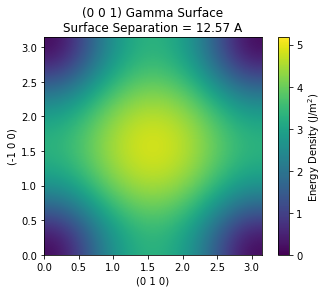

In [21]:
surface.plot_gamma_surface(si=True)

We can see that the plot has helpfully labelled the axes with the miller indices, and from this we can see that the potential thinks that the system will want to glide in the (010) and (100) directions.

## Stacking Faults and Gamma Surfaces in Multi-species Systems
The `GammaSurface` and `StackingFault` classes handle input arguments in a similar way to the classes in `matscipy.disocation`, in that instead of supplying a lattice parameter + crystalstructure + symbol, we can instead supply a bulk structure in the form of an Atoms object. This use-case follows similar caveats to the dislocation systems in complex systems, in that we are limited to systems that can be expressed in a cubic cell. Generating stacking faults from dislocations (as in the first section) also requires that the input bulk shares geometry with the "base" crystalstructure of that dislocation (e.g. the DiamondGlideScrew example will be fine in crystal systems like Diamond and Zincblende, as Zincblende has equivalent geometry).

To repeat the GaAs example from the multispecies dislocation documentation:

In [22]:
from ase.build import bulk

# Data from https://doi.org/10.1080/08927022.2011.602975
alat = 11.2402/2

GaAs = bulk("GaAs", crystalstructure="zincblende", cubic=True, a=alat)

surface = StackingFault(GaAs, DiamondGlideScrew)

surface.generate_images(32)

show_stacking_fault(surface.images)